# Deep Q-Learning for Atari Games
## Learning to play Space Invaders

#### Load required packages

In [1]:
import random, math
from collections import deque
from IPython import display
import matplotlib.pyplot as plt
import pickle
import logging
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.autograd as autograd

import gym
from gym import wrappers

from lib import atari_wrappers

#### Function for plotting average score during training

In [2]:
def plot_score(mean_episode_score, episode):
        plt.figure()
        plt.title('Average Score (over last 100 episodes): ' + str(int(mean_episode_score[-1])) + '  / Episode: ' + str(episode))
        plt.xlabel('Episode (x 100)')
        plt.ylabel('Average Score (over last 100 episodes)')
        plt.plot(mean_episode_score)
        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.pause(1e-6)

#### Here we define the device for the PyTorch computation to run on

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
print(use_cuda)
print(device)

True
cuda


#### The agent neural network

It is a common practice in PyTorch to define your neural network in a class that extends the **nn.Module** class. In this way, you define the neural network building blocks (usually layers) in the class initialization, and then define only the forward pass operations of your network in the **forward** method.

Here we define a Convolutional Neural Network that builds a vector representation of the image information given by the game environment and then uses that vector representation in a feed forward network that computes a Q-value for each possible game action in the environment.

In [4]:
class DQNModel(nn.Module):
    def __init__(self):
        super(DQNModel, self).__init__()
        
        self.conv = nn.Sequential(nn.Conv2d(4, 32, kernel_size=8, stride=4), nn.ReLU(),
                                  nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(),
                                  nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU())
        self.fc = nn.Sequential(nn.Linear(7 * 7 * 64, 512), nn.ReLU(), nn.Linear(512, n_actions))

    def forward(self, obs):
        obs = self.conv(obs)
        obs = obs.view(obs.shape[0], obs.shape[1] * obs.shape[2] * obs.shape[3])
        actions = self.fc(obs)
        return actions

#### Instantiate the game environment

##### We use the environment for the classic Space Invaders game.

##### Here we use the Deepmind's wrappers to rescale the image to 84 x 84, single gray scale channel, and stack 4 consecutive frames of the game as one observation.

In [5]:
env = atari_wrappers.make_atari('SpaceInvadersNoFrameskip-v4')
env = atari_wrappers.wrap_deepmind(env, clip_rewards=True, frame_stack=True, pytorch_img=True)

#### Observation and action spaces

In [6]:
env.observation_space

Box(4, 84, 84)

In [7]:
action_space = [a for a in range(env.action_space.n)]
action_space

[0, 1, 2, 3, 4, 5]

In [8]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

#### Neural Network model objects for the Deep Q-Learning algorithm

##### Here we instantiate the model objects. We will be working with two models: one for the **estimate** network and other for the **target** network. The **estimate** network computes Q-values for the executed actions and the **target** network computes Q-values for the expected Q-values.

In [9]:
n_actions = len(action_space)

lr = 0.00025
alpha = 0.95

policy_model = DQNModel().to(device)
target_model = DQNModel().to(device)
target_model.load_state_dict(policy_model.state_dict())

optimizer = torch.optim.RMSprop(policy_model.parameters(), lr=lr, alpha=alpha)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(policy_model)
print("Number of learnable parameters: %d" % count_parameters(policy_model))

DQNModel(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
Number of learnable parameters: 1687206


#### Agent parameters

##### Here we define the macro parameters used by the agent when interacting with the environment in the main training loop.

In [10]:
max_episodes = 20000
batch_size = 64
target_update = 5000
gamma = 0.99
rep_buf_size = 500000
rep_buf_ini = 50000
skip_frame = 4

#### Epsilon-Greedy exploration

##### We use an annealing scheme for decreasing the **epsilon** parameter, which controls the exploration vs exploitation tradeoff during training. The idea is to allow the agent to explore a lot in the beginning and then making it to choose more “ informed” actions as the model converges.

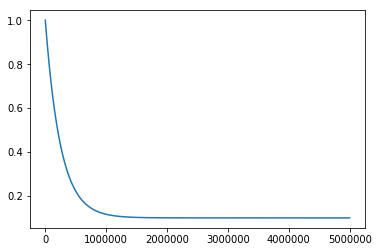

In [11]:
epsilon_start = 1.0
epsilon_final = 0.1
epsilon_decay = 250000

epsilon_by_frame = lambda step_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * step_idx / epsilon_decay)

plt.plot([epsilon_by_frame(i) for i in range(5000000)])

#### The Experience Replay buffer

##### Here we define the experience replay buffer, which allows the agent to store tuples of (state, action, reward, next state, done), which are the experiences it collects when interacting with the game environment. This buffer has a fixed capacity (in number of tuples), so that when maximum capacity is reached the oldest tuple is removed so that a new one can be inserted.

##### This buffer also has a method for the agent to sample experiences at random in order to construct mini-batches of experiences used to train the neural network model.

In [12]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append([state, action, reward, next_state, done])
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

#### Huber Loss

##### Here we implement the Huber loss function, which makes gradient updates smoother because it makes the network less sensitive to large errors than the loss function based on the Mean Squared Error.

In [13]:
def huber_loss(input, target, beta=1, size_average=True):
    """
    very similar to the smooth_l1_loss from pytorch, but with
    the extra beta parameter
    """
    n = torch.abs(input - target)
    cond = n < beta
    loss = torch.where(cond, 0.5 * n ** 2 / beta, n - 0.5 * beta)
    if size_average:
        return loss.mean()
    return loss.sum()

#### Experience Replay buffer Initialization

##### We initialize the Experience Replay buffer to its entire capacity with random playing

In [ ]:
replay_buffer = ReplayBuffer(rep_buf_size)

while len(replay_buffer) < rep_buf_ini:
    
    observation = env.reset()
    done = False
    
    while not done:

        with torch.no_grad():
            t_observation = torch.from_numpy(observation).float().to(device)
            t_observation = t_observation.view(1, t_observation.shape[0], t_observation.shape[1], t_observation.shape[2])
            action = random.sample(range(len(action_space)), 1)[0]
        
        next_observation, reward, done, info = env.step(action_space[action])
            
        replay_buffer.push(observation, action, reward, next_observation, done)
        observation = next_observation
        
print('Experience Replay buffer initialized')

#### Logging

In [ ]:
logger = logging.getLogger('dqn_spaceinvaders')
logger.setLevel(logging.INFO)
logger_handler = logging.FileHandler('./data/dqn_spaceinvaders.log')
logger.addHandler(logger_handler)

#### Agent training loop

##### Here we train the agent for a fixed number of episodes. For each episode, the agent keeps track of the current observation, selects and execute an action and collect feedback from the game environment which are the next observation, the immediate reward received, and a flag indicating if the game is done or not and inserts this experience in the buffer.

##### For our Space Invaders game in the Atari environment, we consider one episode complete after the agent loses one of its 3 available lives.

##### After each **skip_frame** number of game frames played, we update the agent policy, which is the Deep Q-Network that computes the Q-Value estimates, by sampling a mini-batch of experiences from the buffer and updating the network parameters. We also update the target network after a **target_update** fixed number of game frames.

##### Finally, we plot and log the average score in the game so far, across the latest 100 game episodes. We also save these scores to be plotted later. And we save the model dictionary to disk each 1000 episodes.

In [ ]:
episode_score = []
mean_episode_score = []

num_frames = 0
episode = 0
score = 0

while episode < max_episodes:
    
    observation = env.reset()
    done = False
    
    while not done:

        with torch.no_grad():

            t_observation = torch.from_numpy(observation).float().to(device) / 255
            t_observation = t_observation.view(1, t_observation.shape[0], t_observation.shape[1], t_observation.shape[2])
            epsilon = epsilon_by_frame(num_frames)
            if random.random() > epsilon:
                q_value = policy_model(t_observation)
                action = q_value.argmax(1).data.cpu().numpy().astype(int)[0]
            else:
                action = random.sample(range(len(action_space)), 1)[0]
        
        next_observation, reward, done, info = env.step(action_space[action])
        num_frames += 1
        score += reward
            
        replay_buffer.push(observation, action, reward, next_observation, done)
        observation = next_observation
        
        # Update policy
        if len(replay_buffer) > batch_size and num_frames % skip_frame == 0:
            observations, actions, rewards, next_observations, dones = replay_buffer.sample(batch_size)          

            observations = torch.from_numpy(np.array(observations) / 255).float().to(device)
            
            actions = torch.from_numpy(np.array(actions).astype(int)).float().to(device)
            actions = actions.view(actions.shape[0], 1)
            
            rewards = torch.from_numpy(np.array(rewards)).float().to(device)
            rewards = rewards.view(rewards.shape[0], 1)
            
            next_observations = torch.from_numpy(np.array(next_observations) / 255).float().to(device)
            
            dones = torch.from_numpy(np.array(dones).astype(int)).float().to(device)
            dones = dones.view(dones.shape[0], 1)
            
            q_values = policy_model(observations)
            next_q_values = target_model(next_observations)

            q_value = q_values.gather(1, actions.long())
            next_q_value = next_q_values.max(1)[0].unsqueeze(1)
            expected_q_value = rewards + gamma * next_q_value * (1 - dones)

            loss = huber_loss(q_value, expected_q_value)

            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            
        if num_frames % target_update == 0:
            target_model.load_state_dict(policy_model.state_dict())
    
    episode += 1
    episode_score.append(score)
    
    if info['ale.lives'] == 0:
        score = 0
    
    if episode % 100 == 0:
        mean_score = np.mean(episode_score)
        mean_episode_score.append(mean_score)
        episode_score = []
        logger.info('Frame: ' + str(num_frames) + ' / Episode: ' + str(episode) + ' / Average Score (over last 100 episodes): ' + str(int(mean_score)))
        plot_score(mean_episode_score, episode)
        pickle.dump(mean_episode_score, open('./data/dqn_spaceinvaders_mean_scores.pickle', 'wb'))
        
    if episode % 1000 == 0:
        torch.save(policy_model.state_dict(), './data/dqn_spaceinvaders_model_state_dict.pt')

#### Loading and plotting the curve of the average score each 100 episodes for a trained policy over 12,000 episodes

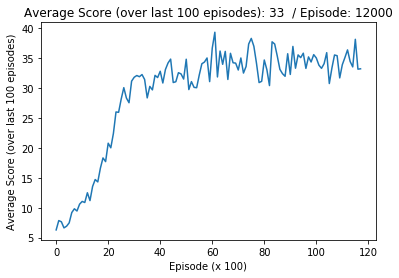

In [14]:
mean_episode_score = pickle.load(open('./data/dqn_spaceinvaders_mean_scores.pickle', "rb"))

plot_score(mean_episode_score, 12000)

#### Loading the network parameters of the trained policy

In [ ]:
policy_model = DQNModel().to(device)
policy_model.load_state_dict(torch.load('./data/dqn_spaceinvaders_model_state_dict.pt'))
policy_model.eval()

#### Loading the game environment

In [ ]:
env = atari_wrappers.make_atari('SpaceInvadersNoFrameskip-v4')
env = atari_wrappers.wrap_deepmind(env, clip_rewards=True, frame_stack=True, pytorch_img=True)

#### Playing the game with a trained agent

##### Here we test a trained agent in a loop like the training loop defined before, except that here we choose the action in a greedily manner and don’t store experiences in the buffer neither update the policy parameters.

##### We run the loop for 3 episodes, corresponding to the 3 available lives in one game play.

In [ ]:
num_episodes = 3
episode = 1

plt.figure(figsize = (6,9))
img = plt.imshow(env.render(mode='rgb_array'))

while episode <= num_episodes:
    
    observation = env.reset()
    score = 0
    done = False
    episode += 1
    
    while not done:
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        with torch.no_grad():

            t_observation = torch.from_numpy(observation).float().to(device) / 255
            t_observation = t_observation.view(1, t_observation.shape[0], t_observation.shape[1], t_observation.shape[2])
            q_value = policy_model(t_observation)
            action = q_value.argmax(1).data.cpu().numpy().astype(int)[0]
        
        next_observation, reward, done, info = env.step(action_space[action])
        
        observation = next_observation

#### Playing the game with a random agent

##### We define here a random agent just as a baseline to compare to trained agents. As the name suggests, this agent executes random actions in the environment. Those actions are chosen randomly from the set of actions available to the game environment.

In [ ]:
num_episodes = 10
episode = 1

plt.figure(figsize = (6,9))
img = plt.imshow(env.render(mode='rgb_array'))

while episode <= num_episodes:
    
    observation = env.reset()
    score = 0
    done = False
    episode += 1
    
    while not done:
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        action = random.sample(range(len(action_space)), 1)[0]
        
        next_observation, reward, done, info = env.step(action_space[action])
        
        observation = next_observation